# Container Dwell Time Analysis
## December 2024 Data Analysis

This notebook showcases the key findings from our container dwell time analysis, focusing on:
1. Distribution modeling and comparison
2. Cycle analysis and patterns
3. Container type comparisons (Dry vs Reefer)

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
# Read and prepare data
df = pd.read_csv('merged_results_final_december.csv')

# Convert dates to datetime
df['DischargedDate'] = pd.to_datetime(df['DischargedDate'], errors='coerce', utc=True).dt.tz_localize(None)
df['GateOutDate'] = pd.to_datetime(df['GateOutDate'], errors='coerce', utc=True).dt.tz_localize(None)

# Calculate dwell times
both_dates = df[df['DischargedDate'].notna() & df['GateOutDate'].notna()].copy()
both_dates['dwell_time_days'] = (both_dates['GateOutDate'] - both_dates['DischargedDate']).dt.total_seconds() / (24*60*60)

# Categorize containers
def categorize_container(iso_code):
    if pd.isna(iso_code):
        return 'Unknown'
    iso_code = str(iso_code).upper()
    return 'Reefer' if 'R' in iso_code else 'Dry'

both_dates['container_category'] = both_dates['IsoCode'].apply(categorize_container)

# Print basic statistics
print(f"Total containers: {len(df):,}")
print(f"Containers with complete dwell times: {len(both_dates):,}")
print(f"\nAverage dwell time: {both_dates['dwell_time_days'].mean():.1f} days")
print(f"Median dwell time: {both_dates['dwell_time_days'].median():.1f} days")
print(f"95th percentile dwell time: {both_dates['dwell_time_days'].quantile(0.95):.1f} days")

# Container type distribution
type_dist = both_dates['container_category'].value_counts()
print("\nContainer Type Distribution:")
print(type_dist)
print("\nPercentages:")
print(type_dist / len(both_dates) * 100)

Total containers: 51,099
Containers with complete dwell times: 42,173

Average dwell time: 3.1 days
Median dwell time: 2.9 days
95th percentile dwell time: 7.1 days

Container Type Distribution:
container_category
Dry       39916
Reefer     2257
Name: count, dtype: int64

Percentages:
container_category
Dry       94.648235
Reefer     5.351765
Name: count, dtype: float64


## Distribution Model Comparison

We compare different statistical models to understand the dwell time distribution:
1. Gaussian Kernel Density Estimation (KDE)
2. Circular KDE (accounting for weekly patterns)
3. Normal Distribution
4. Fourier Series


Dry Containers Model Comparison:


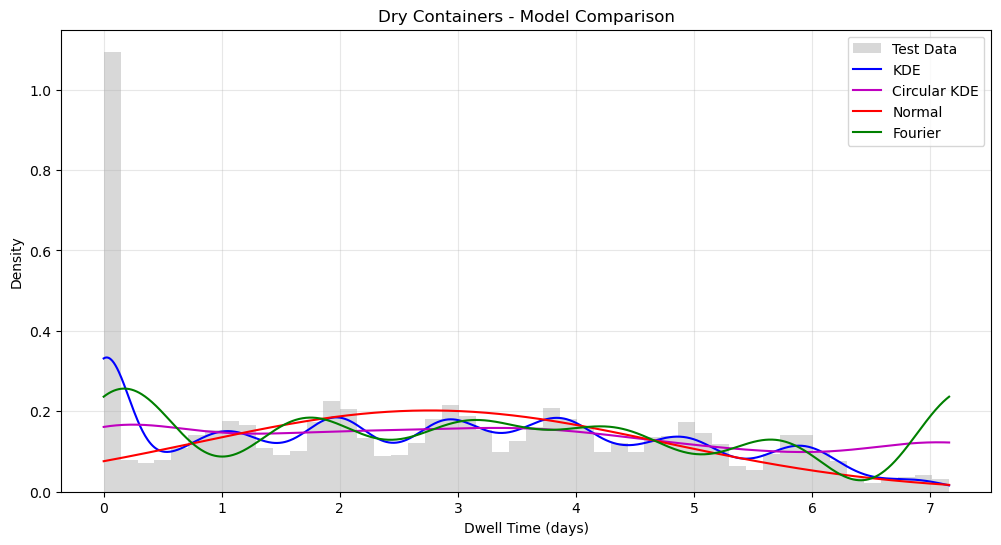

                 MAE    RMSE  Improvement vs Normal (%)
KDE           0.0373  0.1132                    32.4314
Circular KDE  0.0610  0.1404                   -10.5327
Normal        0.0552  0.1503                     0.0000
Fourier       0.0670  0.1359                   -21.4919

Reefer Containers Model Comparison:


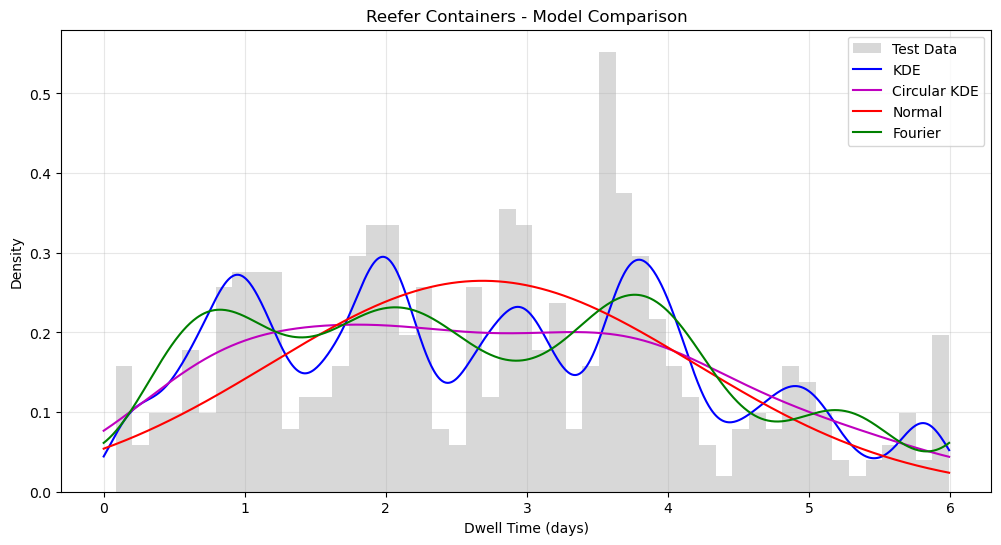

                 MAE    RMSE  Improvement vs Normal (%)
KDE           0.0558  0.0779                    28.0877
Circular KDE  0.0766  0.0956                     1.2497
Normal        0.0776  0.1002                     0.0000
Fourier       0.0744  0.0934                     4.0488


In [3]:
def circular_kde(data, x, bw=0.1, period=7):
    wrapped_data = np.concatenate([data - period, data, data + period])
    kde = gaussian_kde(wrapped_data, bw_method=bw)
    density = kde(x)
    density_left = kde(x - period)
    density_right = kde(x + period)
    return density + density_left + density_right

def fourier_series(x, *params):
    n_terms = (len(params) - 1) // 2
    result = params[0] / 2
    for i in range(n_terms):
        n = i + 1
        a = params[2*i + 1]
        b = params[2*i + 2]
        result += a * np.cos(n * x) + b * np.sin(n * x)
    return result

def evaluate_models(data, category):
    # Filter outliers using 95th percentile
    data_filtered = data[data <= np.percentile(data, 95)]
    
    # Split data
    X_train, X_test = train_test_split(data_filtered, test_size=0.2, random_state=42)
    
    hist_train, bin_edges = np.histogram(X_train, bins=50, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Fit models
    kde = gaussian_kde(X_train, bw_method=0.1)
    mu, std = norm.fit(X_train)
    
    # Prepare data for Fourier series
    x_scaled = bin_centers / np.max(bin_centers) * 2 * np.pi
    n_terms = 5
    p0 = [1.0] + [0.1] * (2 * n_terms)
    fourier_params, _ = curve_fit(fourier_series, x_scaled, hist_train, p0=p0, maxfev=10000)
    
    x_plot = np.linspace(0, np.max(data_filtered), 1000)
    x_plot_scaled = x_plot / np.max(data_filtered) * 2 * np.pi
    
    # Calculate densities
    kde_density = kde(x_plot)
    circular_density = circular_kde(X_train, x_plot)
    normal_density = norm.pdf(x_plot, mu, std)
    fourier_density = fourier_series(x_plot_scaled, *fourier_params)
    fourier_density = np.maximum(fourier_density, 0)
    fourier_density = fourier_density / np.trapz(fourier_density, x_plot)
    
    # Plot distributions
    plt.figure(figsize=(12, 6))
    plt.hist(X_test, bins=50, density=True, alpha=0.3, color='gray', label='Test Data')
    plt.plot(x_plot, kde_density, 'b-', label='KDE')
    plt.plot(x_plot, circular_density, 'm-', label='Circular KDE')
    plt.plot(x_plot, normal_density, 'r-', label='Normal')
    plt.plot(x_plot, fourier_density, 'g-', label='Fourier')
    
    plt.title(f'{category} Containers - Model Comparison')
    plt.xlabel('Dwell Time (days)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate errors on test set
    hist_test, _ = np.histogram(X_test, bins=50, density=True)
    x_test = bin_centers
    
    kde_test = kde(x_test)
    circular_test = circular_kde(X_train, x_test)
    circular_test = circular_test / np.trapz(circular_test, x_test)
    normal_test = norm.pdf(x_test, mu, std)
    x_test_scaled = x_test / np.max(data_filtered) * 2 * np.pi
    fourier_test = fourier_series(x_test_scaled, *fourier_params)
    fourier_test = np.maximum(fourier_test, 0)
    fourier_test = fourier_test / np.trapz(fourier_test, x_test)
    
    # Calculate errors
    kde_mae = mean_absolute_error(hist_test, kde_test)
    circular_mae = mean_absolute_error(hist_test, circular_test)
    normal_mae = mean_absolute_error(hist_test, normal_test)
    fourier_mae = mean_absolute_error(hist_test, fourier_test)
    
    kde_rmse = np.sqrt(mean_squared_error(hist_test, kde_test))
    circular_rmse = np.sqrt(mean_squared_error(hist_test, circular_test))
    normal_rmse = np.sqrt(mean_squared_error(hist_test, normal_test))
    fourier_rmse = np.sqrt(mean_squared_error(hist_test, fourier_test))
    
    return pd.DataFrame({
        'MAE': [kde_mae, circular_mae, normal_mae, fourier_mae],
        'RMSE': [kde_rmse, circular_rmse, normal_rmse, fourier_rmse],
        'Improvement vs Normal (%)': [
            (normal_mae - kde_mae) / normal_mae * 100,
            (normal_mae - circular_mae) / normal_mae * 100,
            0.0,
            (normal_mae - fourier_mae) / normal_mae * 100
        ]
    }, index=['KDE', 'Circular KDE', 'Normal', 'Fourier'])

# Analyze each container type
results = {}
for category in ['Dry', 'Reefer']:
    print(f"\n{category} Containers Model Comparison:")
    data = both_dates[both_dates['container_category'] == category]['dwell_time_days'].values
    results[category] = evaluate_models(data, category)
    print(results[category].round(4))

## Cycle Analysis

Here we analyze the cyclical patterns in container movements using Gaussian Mixture Models (GMM) and temporal analysis. We exclude containers with dwell times less than 0.2 days to focus on meaningful patterns.


Dry Containers Analysis:


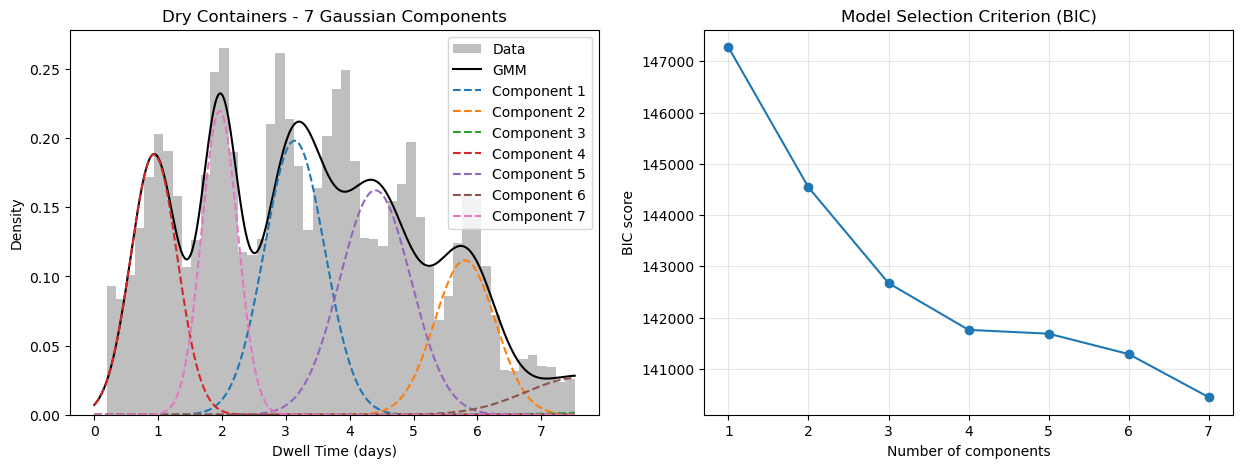


Dry Containers GMM Components:
   Weight  Mean (days)  Std Dev (days)
0   0.234        3.136           0.472
1   0.133        5.805           0.476
2   0.021       10.050           1.521
3   0.173        0.935           0.366
4   0.226        4.401           0.555
5   0.057        7.597           0.850
6   0.156        1.964           0.283

Reefer Containers Analysis:


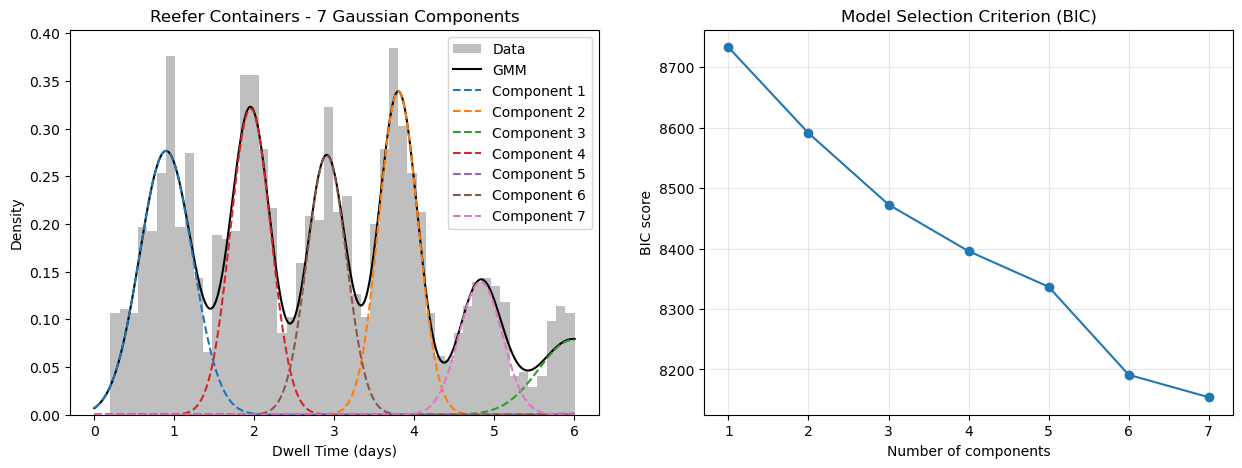


Reefer Containers GMM Components:
   Weight  Mean (days)  Std Dev (days)
0   0.229        0.897           0.330
1   0.207        3.801           0.244
2   0.085        5.985           0.430
3   0.202        1.954           0.251
4   0.015        8.401           1.532
5   0.168        2.906           0.247
6   0.094        4.831           0.269


In [4]:
def analyze_cycles(data, category):
    # Filter out containers with dwell time < 0.2 days
    data = data[data >= 0.2]
    
    # Reshape data for GMM
    X = data.reshape(-1, 1)
    
    # Find optimal number of components
    n_components_range = range(1, 8)
    bic = []
    lowest_bic = np.inf
    best_gmm = None
    
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
    
    optimal_components = n_components_range[np.argmin(bic)]
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Plot 1: GMM components
    plt.subplot(1, 2, 1)
    x_plot = np.linspace(0, np.percentile(data, 95), 1000).reshape(-1, 1)
    plt.hist(data[data <= np.percentile(data, 95)], bins=50, density=True, alpha=0.5, color='gray', label='Data')
    
    logprob = best_gmm.score_samples(x_plot)
    responsibilities = best_gmm.predict_proba(x_plot)
    pdf = np.exp(logprob)
    plt.plot(x_plot, pdf, 'k-', label='GMM')
    
    for i in range(optimal_components):
        pdf_component = responsibilities[:, i] * pdf
        plt.plot(x_plot, pdf_component, '--', label=f'Component {i+1}')
    
    plt.title(f'{category} Containers - {optimal_components} Gaussian Components')
    plt.xlabel('Dwell Time (days)')
    plt.ylabel('Density')
    plt.legend()
    
    # Plot 2: BIC scores
    plt.subplot(1, 2, 2)
    plt.plot(n_components_range, bic, 'o-')
    plt.title('Model Selection Criterion (BIC)')
    plt.xlabel('Number of components')
    plt.ylabel('BIC score')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print component parameters
    print(f"\n{category} Containers GMM Components:")
    components_df = pd.DataFrame({
        'Weight': best_gmm.weights_,
        'Mean (days)': best_gmm.means_.flatten(),
        'Std Dev (days)': np.sqrt(best_gmm.covariances_.flatten())
    })
    print(components_df.round(3))
    
    return best_gmm

# Analyze each container type
for category in ['Dry', 'Reefer']:
    print(f"\n{category} Containers Analysis:")
    data = both_dates[both_dates['container_category'] == category]['dwell_time_days'].values
    if len(data) > 0:
        gmm = analyze_cycles(data, category)

## Temporal Patterns

Analysis of daily and hourly patterns in container movements.

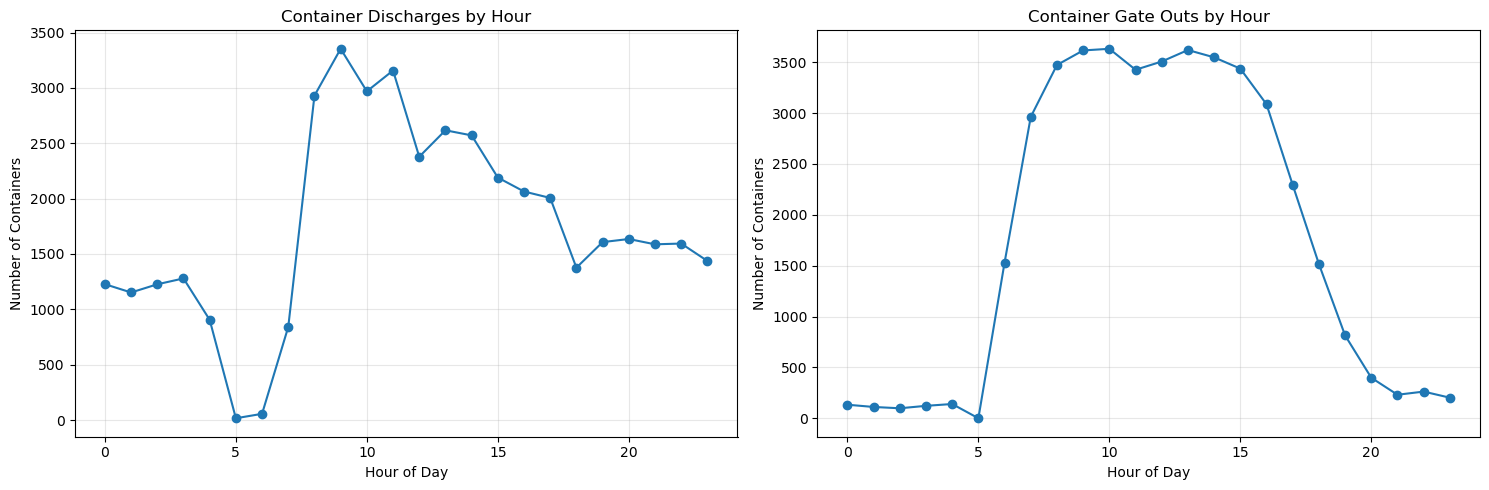

Peak Hours:
Discharge: Hour 9 (3,353 containers)
Gate Out: Hour 10 (3,632 containers)


In [5]:
# Add temporal features
both_dates['discharge_hour'] = both_dates['DischargedDate'].dt.hour
both_dates['discharge_dow'] = both_dates['DischargedDate'].dt.dayofweek
both_dates['gateout_hour'] = both_dates['GateOutDate'].dt.hour
both_dates['gateout_dow'] = both_dates['GateOutDate'].dt.dayofweek

# Plot hourly patterns
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
hourly_discharge = both_dates.groupby('discharge_hour')['ContainerId'].count()
plt.plot(hourly_discharge.index, hourly_discharge.values, 'o-')
plt.title('Container Discharges by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Containers')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
hourly_gateout = both_dates.groupby('gateout_hour')['ContainerId'].count()
plt.plot(hourly_gateout.index, hourly_gateout.values, 'o-')
plt.title('Container Gate Outs by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Containers')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print peak hours
print("Peak Hours:")
print(f"Discharge: Hour {hourly_discharge.idxmax()} ({hourly_discharge.max():,.0f} containers)")
print(f"Gate Out: Hour {hourly_gateout.idxmax()} ({hourly_gateout.max():,.0f} containers)")